# Log-Probability Bias Analysis: LLaMA vs Mixtral vs Human

This notebook tests whether using the same model (e.g., LLaMA) to both generate text and then "score" it with token-level log probabilities yields a "self-scoring bias"; i.e., the generator's own text appears “easier” (higher log p, less negative) than text from other sources. We compare:

We analyze distribution differences using:
- Summary statistics (mean, std, quantiles, skew, kurtosis)
- Kolmogorov–Smirnov (KS) distance between empirical CDFs
- Jensen–Shannon Divergence (JSD)
- KL Divergence
- Wasserstein Earth-Mover distance

In [7]:
import os
# --- REQUIRED: your single-file NPZ paths (same document across sources) ---
human_npz_path   = "data/tokens/human/reuter5050/C50train/AaronPressman/407599newsML.txt.npz"
llama_npz_path   = "data/tokens/llama70Bw4a16/reuter5050/C50train/AaronPressman/407599newsML.txt.npz"
mixtral_npz_path = "data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train/AaronPressman/407599newsML.txt.npz"

# --- OPTIONAL: aggregate (multi-file) analysis ---
# Point each directory to a folder of NPZ files for the SAME AUTHOR, ideally ~50 files.
human_dir   = "data/tokens/human/reuter5050/C50train/AaronPressman"
llama_dir   = "data/tokens/llama70Bw4a16/reuter5050/C50train/AaronPressman"
mixtral_dir = "data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train/AaronPressman"

# Plotting and binning
BINS = 100
ROLLING_WINDOW = 64  # for burstiness plots
AGG_MAX_FILES = 100  # safety cap if directory has more than 50 files

# Output paths
SUMMARY_CSV_SINGLE = "eda_outputs/logprobs/logprob_stats_single.csv"
SUMMARY_CSV_AGG    = "eda_outputs/logprobs/logprob_stats_aggregate.csv"
DIVERGENCE_CSV_SINGLE = "eda_outputs/logprobs/logprob_divergences_single.csv"
DIVERGENCE_CSV_AGG    = "eda_outputs/logprobs/logprob_divergences_aggregate.csv"
os.makedirs("eda_outputs/logprobs")
print(f"Loaded paths & variables")

Loaded paths & variables


In [2]:
import os, math, glob
from typing import Dict, Any, Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fingerprinting_llms.score import LogProbs
#   dataclass with:
#       -  decoded_tokens: npt.NDArray[np.str_]
#       -  token_ids: npt.NDArray[np.int32]
#       -  token_ranks: list[np.int16]
#       -  token_probs: list[np.float32]

def clean_series(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float).reshape(-1)
    return x[np.isfinite(x)]

def load_logprobs(npz_path: str):
    lp = LogProbs.from_file(npz_path)
    return clean_series(np.asarray(lp.token_probs))

def describe_series(name: str, x: np.ndarray) -> Dict[str, float]:
    q = np.quantile(x, [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    return {
        "name": name,
        "n": int(len(x)),
        "mean": float(np.mean(x)),
        "std": float(np.std(x, ddof=0)),
        "min": float(np.min(x)),
        "p01": float(q[0]),
        "p05": float(q[1]),
        "p25": float(q[2]),
        "p50": float(q[3]),
        "p75": float(q[4]),
        "p95": float(q[5]),
        "p99": float(q[6]),
        "max": float(np.max(x)),
        "skew": float(((x - x.mean())**3).mean() / (x.std()**3 + 1e-12)),
        "kurtosis_excess": float(((x - x.mean())**4).mean() / (x.var()**2 + 1e-12) - 3.0),
    }

def ecdf(x: np.ndarray):
    x_sorted = np.sort(x)
    y = np.arange(1, len(x_sorted)+1) / len(x_sorted)
    return x_sorted, y

def ks_distance(x: np.ndarray, y: np.ndarray) -> float:
    xs, Fx = ecdf(x)
    ys, Gy = ecdf(y)
    i = j = 0
    D = 0.0
    while i < len(xs) and j < len(ys):
        if xs[i] < ys[j]:
            F = i / len(xs)
            G = j / len(ys)
            D = max(D, abs(F - G))
            i += 1
        elif xs[i] > ys[j]:
            F = i / len(xs)
            G = j / len(ys)
            D = max(D, abs(F - G))
            j += 1
        else:
            F = i / len(xs)
            G = j / len(ys)
            D = max(D, abs(F - G))
            i += 1
            j += 1
    return float(D)

def _hist_smooth(x: np.ndarray, bins: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    hist, edges = np.histogram(x, bins=bins, density=False)
    hist = hist.astype(float)
    hist += 1e-9  # smoothing to avoid zeros
    hist /= hist.sum()
    mids = 0.5 * (edges[:-1] + edges[1:])
    return hist, mids

def kl_divergence(p: np.ndarray, q: np.ndarray) -> float:
    return float(np.sum(p * (np.log(p) - np.log(q))))

def js_divergence(p: np.ndarray, q: np.ndarray) -> Tuple[float, float]:
    m = 0.5 * (p + q)
    d = 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    return float(d), float(np.sqrt(d))

def wasserstein_1(x: np.ndarray, y: np.ndarray, n_grid: int = 1000) -> float:
    qs = np.linspace(0.0, 1.0, n_grid)
    xq = np.quantile(x, qs)
    yq = np.quantile(y, qs)
    return float(np.mean(np.abs(xq - yq)))

def rolling_mean(x: np.ndarray, window: int) -> np.ndarray:
    if window <= 1 or window > len(x):
        return x.copy()
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    out = (cumsum[window:] - cumsum[:-window]) / float(window)
    pad = np.full(window-1, np.nan)
    return np.concatenate([pad, out])


## Single-document comparison

We first compare a **single document** across sources. All three NPZ files should correspond to the **same underlying text** (human-written, LLaMA-generated, Mixtral-generated variants), each **scored under LLaMA** to test whether LLaMA assigns systematically higher log probabilities to its own generations.


In [5]:
human_lp   = load_logprobs(human_npz_path)
llama_lp   = load_logprobs(llama_npz_path)
mixtral_lp = load_logprobs(mixtral_npz_path)

print("Loaded token counts:",
      f"Human={human_lp.size}, LLaMA={llama_lp.size}, Mixtral={mixtral_lp.size}")


Loaded token counts: Human=600, LLaMA=479, Mixtral=528


In [6]:
rows = [
    describe_series("Human", human_lp),
    describe_series("LLaMA", llama_lp),
    describe_series("Mixtral", mixtral_lp),
]
summary_single = pd.DataFrame(rows).set_index("name")
display(summary_single)
summary_single.to_csv(SUMMARY_CSV_SINGLE)
print(f"Saved single-doc summary to {SUMMARY_CSV_SINGLE}")


,n,mean,std,min,p01,p05,p25,p50,p75,p95,p99,max,skew,kurtosis_excess
name,,,,,,,,,,,,,,
Human,600,-1.998250,2.435047,-13.200365,-10.460044,-7.336920,-2.689647,-1.097701,-0.235976,-0.004717,-0.000487,-0.000041,-1.839542,3.461763
LLaMA,479,-1.281736,1.941910,-13.937305,-9.265371,-5.502655,-1.507254,-0.637958,-0.108975,-0.001133,-0.000124,-0.000044,-3.002066,11.524375
Mixtral,528,-1.338704,1.961225,-17.797413,-8.024622,-5.258083,-1.795561,-0.671608,-0.053602,-0.000116,-0.000009,0.000000,-3.158127,15.499892


Saved single-doc summary to eda_outputs/logprobs/logprob_stats_single.csv


## Single Document Summary Statistics
- **Mean (log p)** closer to 0 indicates **more likely** tokens under the scorer. 
  - LLaMA shows a higher (less negative) mean than *Human* or *Mixtral*, indicating potential **self-scoring bias**. 
  - However, we see that the difference between Llama and Mixtral appears small, so Llama may not be **significantly** higher than Mixtral.
  - NOTE: this is only a single document, and we should not draw any conclusions from these numbers, only potential **insights**.
  - My intuition is that the LLMs are simply outputting **more probable** tokens on average.  My hope is that this is reflected in the signal.
- **Std** Captures dispersion; a lower std for both LLaMA and Mixtral likely indicate “safer” token choices (less risky sampling).  
- **Quantiles** 
  - Human text includes much deeper low-probability spikes (−10 to −7 range), meaning certain tokens are surprisingly unlikely for the model.  Self-scoring reduces those spikes dramatically.
  - Mixtral has shallower lower tails, suggesting it doesn’t find LLaMA’s text as improbable at any point — perhaps indicating overlap in training distributions.
- **Skew/kurtosis** 
  - Both model-scored distributions show high negative skew, meaning “most tokens are easy, but a few are extremely hard.”
  - High kurtosis means many tokens are assigned similar high probabilities, punctuated by rare extreme deviations.

In [ ]:
# Build common histograms for comparability
p_h, mids = _hist_smooth(human_lp, bins=BINS)
p_l, _    = _hist_smooth(llama_lp, bins=BINS)
p_m, _    = _hist_smooth(mixtral_lp, bins=BINS)

pairs = [
    ("Human", p_h, "LLaMA", p_l),
    ("Human", p_h, "Mixtral", p_m),
    ("LLaMA", p_l, "Mixtral", p_m),
]

div_rows = []
for a_name, a, b_name, b in pairs:
    D_kl_ab = kl_divergence(a, b)
    D_kl_ba = kl_divergence(b, a)
    D_js, d_js_sqrt = js_divergence(a, b)
    D_ks = ks_distance(
        {"Human":human_lp, "LLaMA":llama_lp, "Mixtral":mixtral_lp}[a_name],
        {"Human":human_lp, "LLaMA":llama_lp, "Mixtral":mixtral_lp}[b_name]
    )
    D_w = wasserstein_1(
        {"Human":human_lp, "LLaMA":llama_lp, "Mixtral":mixtral_lp}[a_name],
        {"Human":human_lp, "LLaMA":llama_lp, "Mixtral":mixtral_lp}[b_name]
    )
    div_rows.append({
        "pair": f"{a_name} vs {b_name}",
        "KL(a||b)": D_kl_ab,
        "KL(b||a)": D_kl_ba,
        "JSD": D_js,
        "sqrt(JSD)": d_js_sqrt,
        "KS": D_ks,
        "Wasserstein1": D_w,
    })

div_single = pd.DataFrame(div_rows).set_index("pair")
display(div_single)
div_single.to_csv(DIVERGENCE_CSV_SINGLE)
print(f"Saved single-doc divergences to {DIVERGENCE_CSV_SINGLE}")


,KL(a||b),KL(b||a),JSD,sqrt(JSD),KS,Wasserstein1
pair,,,,,,
Human vs LLaMA,1.777354,0.495981,0.063021,0.251039,0.178987,0.724677
Human vs Mixtral,2.006357,0.342591,0.069296,0.263241,0.131212,0.681874
LLaMA vs Mixtral,0.665032,0.394231,0.030508,0.174665,0.067747,0.133835


Saved single-doc divergences to eda_outputs/logprobs/logprob_divergences_single.csv


**Distribution Comparison:**  
- **KL(a||b)**  is directional — how surprising **a** looks if modeled by **b**’s distribution (larger = more different).  
- **JSD** Jensen–Shannon Divergence is symmetric, bounded (0 to ln(2) in nats; here we use natural log). **sqrt(JSD)** is a true metric; higher means more dissimilar.  
- **KS** Kolmogorov–Smirnov detects the **maximum vertical gap** between ECDFs (shape differences).  
- **Wasserstein-1** measures the **average horizontal transport** needed to morph one distribution into the other (robust to support shifts).

- **KL Divergence**
  - **Human vs LLaMA:** 1.777 / 0.496  
  - **Human vs Mixtral:** 2.006 / 0.343  
  - **LLaMA vs Mixtral:** 0.665 / 0.394  
  - *Interpretation:* Human/model pairs diverge far more than model/model. Slightly lower KL(Human||LLaMA) than KL(Human||Mixtral) hints that LLaMA’s scoring is marginally closer to human text than Mixtral’s.

- **Jensen–Shannon Divergence (and sqrt(JSD))**
  - **Human vs LLaMA:** JSD = 0.063, sqrt(JSD) = 0.251  
  - **Human vs Mixtral:** JSD = 0.069, sqrt(JSD) = 0.263  
  - **LLaMA vs Mixtral:** JSD = 0.031, sqrt(JSD) = 0.175  
  - *Interpretation:* Models appear to more similar to each other than model/human.

- **KS / Wasserstein-1**
  - **Human vs LLaMA:** KS = 0.179, W1 = 0.725  
  - **Human vs Mixtral:** KS = 0.131, W1 = 0.682  
  - **LLaMA vs Mixtral:** KS = 0.068, W1 = 0.134  
  - *Interpretation:* Substantial human/model distance; tight model/model clustering.

- **Overall Interpretation**
  - Higher divergence for Human–Model and lower for Model–Model supports that models “recognize” each other’s token-likelihood profiles but treat human writing as out-of-distribution.  
  - This aligns with **self-similar calibration bias** and suggests **JSD** or **Wasserstein-1** as robust indicators for detecting model-like distributions at scale.

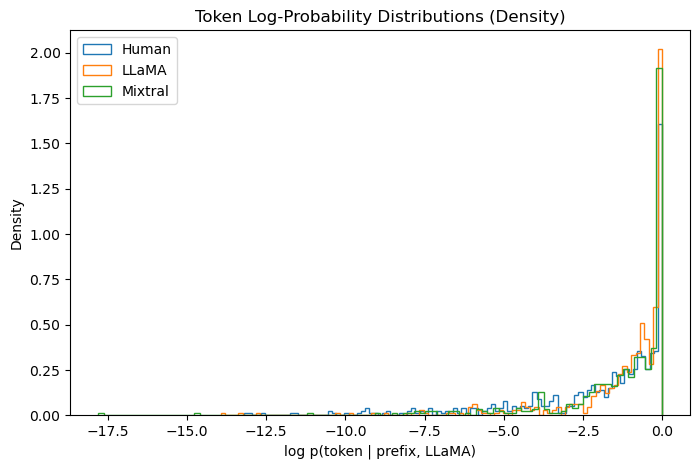

In [10]:
plt.figure(figsize=(8,5))
plt.hist(human_lp, bins=BINS, density=True, histtype="step", label="Human")
plt.hist(llama_lp, bins=BINS, density=True, histtype="step", label="LLaMA")
plt.hist(mixtral_lp, bins=BINS, density=True, histtype="step", label="Mixtral")
plt.title("Token Log-Probability Distributions (Density)")
plt.xlabel("log p(token | prefix, LLaMA)")
plt.ylabel("Density")
plt.legend()
plt.show()


**Histogram interpretation:** There are some interesting peaks for Llama towards the "more probable" part of the histogram, while there are some peaks of much lower probability tokens with the human line.

## Empirical Cumulative Distribution Function (ECDF)

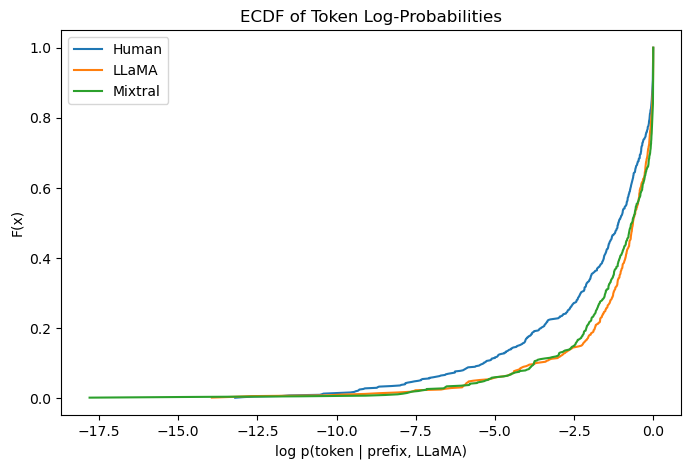

In [ ]:
def plot_ecdf(series_dict):
    plt.figure(figsize=(8,5))
    for name, x in series_dict.items():
        xs, ys = ecdf(x)
        plt.plot(xs, ys, label=name)
    plt.title("ECDF of Token Log-Probabilities")
    plt.xlabel("log p(token | prefix, LLaMA)")
    plt.ylabel("F(x)")
    plt.legend()
    plt.show()

plot_ecdf({"Human": human_lp, "LLaMA": llama_lp, "Mixtral": mixtral_lp})


**ECDF interpretation:** Higher per-token probabilities for LLaMA-generated text under the LLaMA and Mixtral scorers as compared to the human-generated text.  Llama has a bulge towards the "more probable" part of the graph that indicates there is a slight edge to Llama towards more probable as compared with Mixtral scoring.

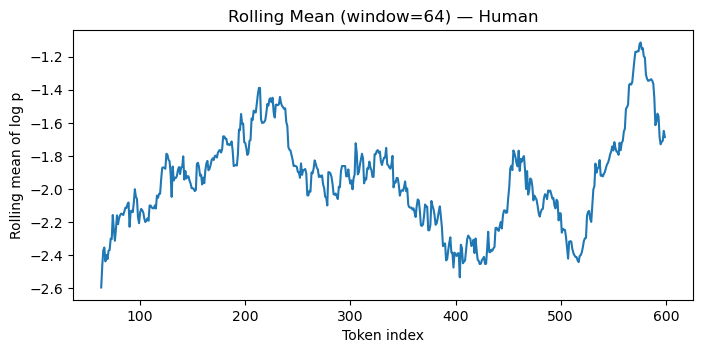

Saved eda_outputs/logprobs/Human_rolling_window.png


<Figure size 640x480 with 0 Axes>

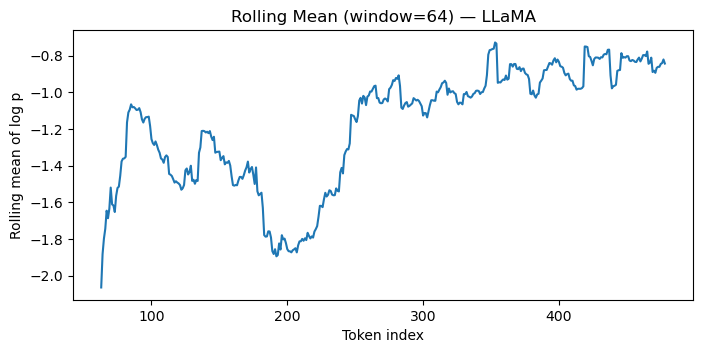

Saved eda_outputs/logprobs/LLaMA_rolling_window.png


<Figure size 640x480 with 0 Axes>

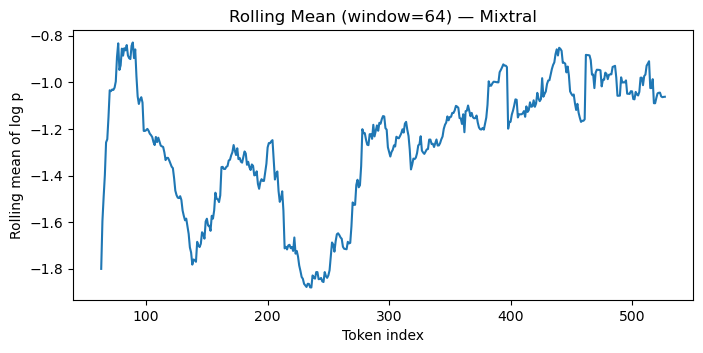

Saved eda_outputs/logprobs/Mixtral_rolling_window.png


<Figure size 640x480 with 0 Axes>

In [ ]:
for name, x in [("Human", human_lp), ("LLaMA", llama_lp), ("Mixtral", mixtral_lp)]:
    rm = rolling_mean(x, ROLLING_WINDOW)
    plt.figure(figsize=(8,3.5))
    plt.plot(rm)
    plt.title(f"Rolling Mean (window={ROLLING_WINDOW}) — {name}")
    plt.xlabel("Token index")
    plt.ylabel("Rolling mean of log p")
    filename=f"eda_outputs/logprobs/{name}_rolling_window.png"
    plt.savefig(f"eda_outputs/logprobs/{name}_rolling_window.png")
    plt.show()
    print(f"Saved {filename}")


**Rolling means:** Highlights **burstiness** or local regions of easy/hard tokens. There is much more "peaky" behavior in the human-generated text, indicating large drops to improbable tokens.  The llama-generate and llama-graded option appears much smoother.  The mixtral-graded llama-generated text is also much smoother than the human-generated text, but is slightly more "peaky" than the llama-graded..

## Aggregate comparison across many documents (e.g., 50 articles by the same author)

To make (slightly more) robust claims, we aggregate **all NPZ files** from a chosen author’s folder for each source:
- Human-generated/llama-graded (HGLG)
- llama-generated/llama-graded (LGLG)
- llama-generated/mixtral-graded (LGMG)

This mitigates single-document idiosyncrasies and exposes stable distributional shifts.


In [15]:
print(f"- Human-generated/llama-graded (HGLG)")
print(f"- llama-generated/llama-graded (LGLG)")
print(f"- llama-generated/mixtral-graded (LGMG)")
def collect_dir(dir_path: str, max_files: int = AGG_MAX_FILES) -> tuple:
    # Collect all token log-probs from NPZs in a directory; also return per-doc stats.
    paths = sorted(glob.glob(os.path.join(dir_path, "*.npz")))[:max_files]
    all_vals = []
    per_doc = []
    for p in paths:
        try:
            x = load_logprobs(p)
            all_vals.append(x)
            per_doc.append({"file": os.path.basename(p), "n": x.size, "mean": float(x.mean()), "std": float(x.std(ddof=0))})
        except Exception as e:
            print("Skipping", p, "->", e)
    agg = np.concatenate(all_vals) if all_vals else np.array([], dtype=float)
    return agg, pd.DataFrame(per_doc)

human_all, human_docstats     = collect_dir(human_dir)
llama_all, llama_docstats     = collect_dir(llama_dir)
mixtral_all, mixtral_docstats = collect_dir(mixtral_dir)

print("Aggregate token counts:",
      f"HGLG={human_all.size}, LGLG={llama_all.size}, LGMG={mixtral_all.size}")
display(human_docstats.head(10))
display(llama_docstats.head(10))
display(mixtral_docstats.head(10))


- Human-generated/llama-graded (HGLG)
- llama-generated/llama-graded (LGLG)
- llama-generated/mixtral-graded (LGMG)
Aggregate token counts: HGLG=26960, LGLG=19176, LGMG=21732


,file,n,mean,std
0,106247newsML.txt.npz,392,-2.233708,2.412234
1,120600newsML.txt.npz,503,-2.366083,2.611875
2,120683newsML.txt.npz,86,-2.439007,2.445427
3,136958newsML.txt.npz,549,-2.061538,2.457299
4,137498newsML.txt.npz,427,-1.986618,2.404780
5,14014newsML.txt.npz,59,-2.400437,2.630892
6,156814newsML.txt.npz,659,-2.370261,2.518289
7,182596newsML.txt.npz,825,-2.147497,2.368748
8,186392newsML.txt.npz,624,-1.960531,2.450180
9,193495newsML.txt.npz,392,-1.852183,2.193728


,file,n,mean,std
0,106247newsML.txt.npz,312,-1.293189,1.996091
1,120600newsML.txt.npz,432,-1.203093,1.922770
2,120683newsML.txt.npz,246,-1.005534,1.609099
3,136958newsML.txt.npz,349,-1.035780,1.893670
4,137498newsML.txt.npz,245,-1.849087,2.230493
5,14014newsML.txt.npz,269,-1.339243,2.013986
6,182596newsML.txt.npz,436,-1.473742,2.002059
7,186392newsML.txt.npz,366,-1.456268,2.094603
8,193495newsML.txt.npz,351,-1.137947,1.674643
9,196805newsML.txt.npz,451,-0.870685,1.522588


,file,n,mean,std
0,106247newsML.txt.npz,378,-1.174230,1.888091
1,120600newsML.txt.npz,486,-1.251710,1.869982
2,120683newsML.txt.npz,276,-1.179790,1.821089
3,136958newsML.txt.npz,390,-1.297494,2.245549
4,137498newsML.txt.npz,270,-1.747276,2.236551
5,14014newsML.txt.npz,313,-1.349632,2.079326
6,156814newsML.txt.npz,489,-1.472694,2.167900
7,182596newsML.txt.npz,495,-1.486181,2.156148
8,186392newsML.txt.npz,419,-1.422452,2.015710
9,193495newsML.txt.npz,376,-1.253509,1.689460


In [16]:
rows_agg = []
if human_all.size:
    rows_agg.append(describe_series("Human", human_all))
else:
    rows_agg.append({"name":"Human"})
if llama_all.size:
    rows_agg.append(describe_series("LLaMA", llama_all))
else:
    rows_agg.append({"name":"LLaMA"})
if mixtral_all.size:
    rows_agg.append(describe_series("Mixtral", mixtral_all))
else:
    rows_agg.append({"name":"Mixtral"})

summary_agg = pd.DataFrame(rows_agg).set_index("name")
display(summary_agg)
summary_agg.to_csv(SUMMARY_CSV_AGG)
print(f"Saved aggregate summary to {SUMMARY_CSV_AGG}")


,n,mean,std,min,p01,p05,p25,p50,p75,p95,p99,max,skew,kurtosis_excess
name,,,,,,,,,,,,,,
Human,26960,-2.079618,2.409202,-18.019508,-10.294854,-7.160229,-3.093871,-1.205666,-0.237751,-0.003693,-2.753546e-04,-1.192093e-07,-1.662312,2.968542
LLaMA,19176,-1.206668,1.933755,-18.765940,-9.904472,-5.194987,-1.465813,-0.480306,-0.050118,-0.000316,-2.270911e-05,-1.192093e-07,-2.982585,10.942837
Mixtral,21732,-1.301980,2.018286,-20.163900,-9.975135,-5.228021,-1.716569,-0.517529,-0.026368,-0.000032,-7.522104e-07,0.000000e+00,-2.934329,11.787331


Saved aggregate summary to eda_outputs/logprobs/logprob_stats_aggregate.csv


##  50-Document Summary Statistics
- The aggregated patterns replicate the single-document trend:  
  - **Models strongly favor the llama-generated text**, assigning higher and more uniform probabilities.  
  - **Human text** occupies a broader distributional region with lower average log probabilities.  

##  Is the LGLG Significantly Higher-Probability than LGMG?
In order to check whether "scoring" Llama-Generated documents with Llama are "biased" towards higher probabilities (than, say, Llama-Generated/Mixtral-Graded) We should perform statistical significance tests.  I will perform:
1. Welch's paired two-sample t-test for statistical significance for difference in means
2. Cohen's d-test for "effect size" of difference in means

### T-Test
- H0: The distributions are the same
- H1: The distributions are different (I'm going to use a symmetric test)

| Group | n | mean | std |
|:--|--:|--:|--:|
| **LLaMA** | 19,176 | -1.2067 | 1.9338 |
| **Mixtral** | 21,732 | -1.3020 | 2.0183 |

- Degrees of freedom ≈ 40,000  
- p-value ≈ 1.1×10⁻⁶; The chance of type I error (rejecting a correct H0) is small: 0.000001103 (0.00011%)
- **Result:** The mean difference (≈ 0.095 log p) is statistically significant.

### D-Test
**Effect size (Cohen’s d = 0.048)**  
- The difference is **statistically detectable but practically small**, suggesting that while LLaMA assigns slightly higher likelihoods to its own tokens, the bias magnitude is modest.

### Result
The large sample size makes the difference significant, but the effect size indicates that LLaMA and Mixtral have nearly identical scoring behavior overall — any “self-scoring bias” appears weak in practical terms.

In [18]:
# Divergences on aggregates
div_rows = []
if human_all.size and llama_all.size and mixtral_all.size:
    p_hA, _ = _hist_smooth(human_all, bins=BINS)
    p_lA, _ = _hist_smooth(llama_all, bins=BINS)
    p_mA, _ = _hist_smooth(mixtral_all, bins=BINS)
    pairsA = [
        ("Human", human_all, p_hA, "LLaMA", llama_all, p_lA),
        ("Human", human_all, p_hA, "Mixtral", mixtral_all, p_mA),
        ("LLaMA", llama_all, p_lA, "Mixtral", mixtral_all, p_mA),
    ]
    for a_name, a_samp, a_hist, b_name, b_samp, b_hist in pairsA:
        D_kl_ab = kl_divergence(a_hist, b_hist)
        D_kl_ba = kl_divergence(b_hist, a_hist)
        D_js, d_js_sqrt = js_divergence(a_hist, b_hist)
        D_ks = ks_distance(a_samp, b_samp)
        D_w  = wasserstein_1(a_samp, b_samp)
        div_rows.append({
            "pair": f"{a_name} (agg) vs {b_name} (agg)",
            "KL(a||b)": D_kl_ab,
            "KL(b||a)": D_kl_ba,
            "JSD": D_js,
            "sqrt(JSD)": d_js_sqrt,
            "KS": D_ks,
            "Wasserstein1": D_w,
        })
div_agg = pd.DataFrame(div_rows).set_index("pair")
display(div_agg)
div_agg.to_csv(DIVERGENCE_CSV_AGG)
print(f"Saved aggregate divergences to {DIVERGENCE_CSV_AGG}")


,KL(a||b),KL(b||a),JSD,sqrt(JSD),KS,Wasserstein1
pair,,,,,,
Human (agg) vs LLaMA (agg),0.156811,0.122653,0.032095,0.179150,0.204269,0.873242
Human (agg) vs Mixtral (agg),0.144633,0.122374,0.029919,0.172971,0.168239,0.787727
LLaMA (agg) vs Mixtral (agg),0.013986,0.023439,0.002481,0.049805,0.050220,0.113508


Saved aggregate divergences to eda_outputs/logprobs/logprob_divergences_aggregate.csv


##  Findings
- **KL Divergence:** Human distributions diverge more strongly from both models than the models diverge from each other.  
- **Jensen–Shannon Divergence (JSD):** Modest separation for Human vs. model(regardless of grader), High overlap for model-generated, model-graded.
- **KS / Wasserstein-1 Distances:** Human–Model distances are several times larger than Model–Model.  
- **RESULT:** Tight clustering among model-generated/model-graded, clear separation of model-generated from human-generated data.

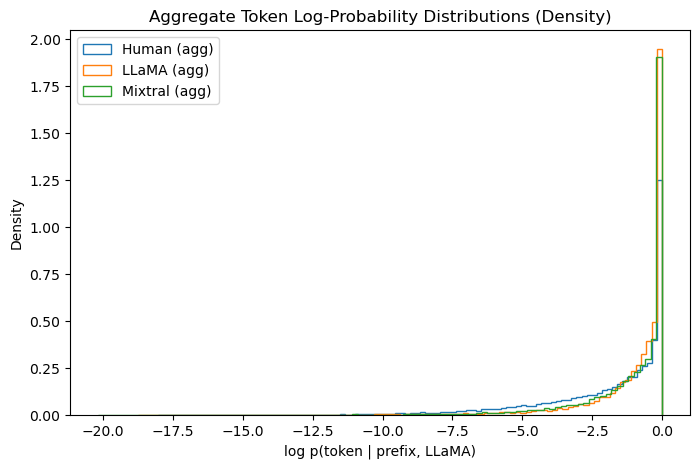

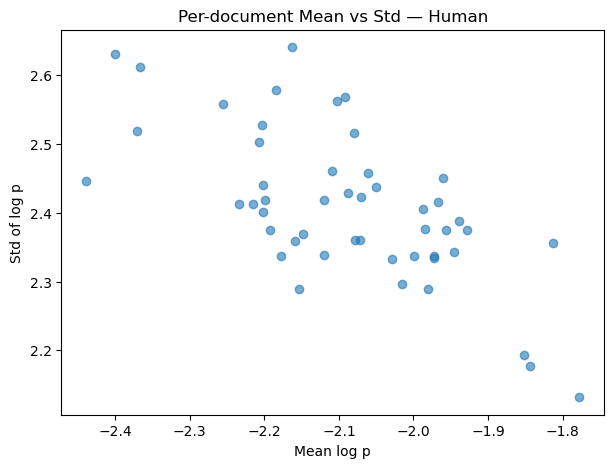

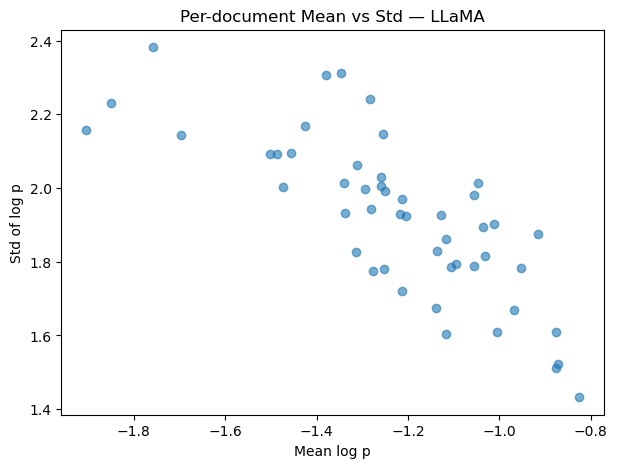

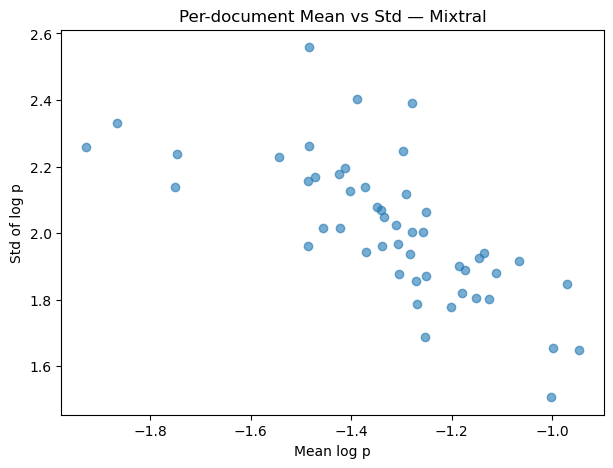

In [21]:
# Aggregate plots
if human_all.size and llama_all.size and mixtral_all.size:
    plt.figure(figsize=(8,5))
    plt.hist(human_all, bins=BINS, density=True, histtype="step", label="Human (agg)")
    plt.hist(llama_all, bins=BINS, density=True, histtype="step", label="LLaMA (agg)")
    plt.hist(mixtral_all, bins=BINS, density=True, histtype="step", label="Mixtral (agg)")
    plt.title("Aggregate Token Log-Probability Distributions (Density)")
    plt.xlabel("log p(token | prefix, LLaMA)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Per-document means & std scatter (each source separately)
    for name, df in [("Human", human_docstats), ("LLaMA", llama_docstats), ("Mixtral", mixtral_docstats)]:
        if not df.empty:
            plt.figure(figsize=(7,5))
            plt.scatter(df["mean"], df["std"], alpha=0.6)
            plt.title(f"Per-document Mean vs Std — {name}")
            plt.xlabel("Mean log p")
            plt.ylabel("Std of log p")
            plt.savefig(f"eda_outputs/logprobs/{name}_agg_meanVstd.png")
            plt.show()


## Results

### Log Probs Density Plots
This appears to match fairly well with what we saw in the single document, with much smoother bulges rather than peaks.  Bottom line: much more density in the lower probability space for human-generated text, with a bulge in the higher probability space for llama-generated and llama-scored.

### Mean/STD charts
- The human-generated mean vs standard deviation chart is more diffuse with less of a clear trend.
- The llama-generated mean vs standard deviation charts show a more clear negative corellation between mean and standard deviation.

## Analysis Bottom Line
- There appears to be a **significant** difference between human-generated and llama-generated texts.
- Log probabilities for the llama-generated text are **fairly similar** between llama-grading and mixtral-grading.
    - Llama's grading of itself indicate higher probability than Mixtral's grading, showing a possible bias (with a fairly small effect size).
    - Both model-graded documents show a smoother rolling window (moving average) chart than human-generated.
- We may want to use a different model for grading than generating for this analysis.